# Trading Crypto

In this notebook we're going to do a what-if analysis based on some trades of Cryptocurrencies. We're going to work out the valuation of our portfolio based on doing some trades and then re-running that valuation as if we hadn't made those trades

In [120]:
# Import LUSID
import lusid
import os
from lusidjam import RefreshingToken
import pandas as pd
import pytz
from datetime import datetime, timedelta
from dateutil.parser import parse
import json
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator
from dateutil.parser import parse


In [6]:
# Authenticate our user and create our API client
secrets_path = os.getenv("FBN_SECRETS_PATH")

api_factory = lusid.utilities.ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename = secrets_path,
    app_name="LusidJupyterNotebook")

In [14]:
api_factory = lusid.utilities.ApiClientFactory(api_secrets_filename="/Users/markneedham/projects/lusid-python-tools/tests/secrets.json")

In [15]:
transaction_portfolios_api = api_factory.build(lusid.api.TransactionPortfoliosApi)
instruments_api = api_factory.build(lusid.api.InstrumentsApi)
quotes_api = api_factory.build(lusid.api.QuotesApi)
aggregation_api = api_factory.build(lusid.api.AggregationApi)
derived_api = api_factory.build(lusid.api.DerivedTransactionPortfoliosApi)

## Instruments Master

We've got a JSON file that contains all sorts of Cryptocurrencies from https://github.com/crypti/cryptocurrencies. et's first parse that file:

In [23]:
with open("data/cryptocurrencies.json", "r") as crypto_file:
    crypto = json.loads(crypto_file.read())

print(f"Number of cryptocurrencies: {len(crypto.items())}")
print({k: v for k,v in list(crypto.items())[:10]})

Number of cryptocurrencies: 3758
{'42': '42 Coin', '300': '300 token', '365': '365Coin', '404': '404Coin', '433': '433 Token', '611': 'SixEleven', '808': '808', '888': 'Octocoin', '1337': 'EliteCoin', '2015': '2015 coin'}


We've got almost 4,000 cryptocurrencies, so we'll have to batch up our import as the Instruments API only lets us import a maximum of 2,000 instruments in one request.

We can import all those instruments using the code below:

In [24]:
definitions = {}
for symbol, name in crypto.items():
    identifiers = {
        "ClientInternal": lusid.models.InstrumentIdValue(value=symbol)
    }
    definitions[name] = lusid.models.InstrumentDefinition(name=name, identifiers=identifiers)
    
    if len(definitions.keys()) == 2000:
        instruments_api.upsert_instruments(request_body=definitions)
        definitions = {}
    
response = instruments_api.upsert_instruments(request_body=definitions)
print(response.failed)

{}


## Create Portfolio

Now that we're got our instruments loaded, we need to create a portfolio to keep track of our trading activity. 

In [27]:
now = datetime.now().strftime('%Y-%m-%d-%H_%M_%S')
scope = portfolio_code = f"Developer-WhatIf-Tutorial-{now}"
print("Portfolio Code", portfolio_code)

created_date = datetime(year=2021, month=1, day=1, tzinfo=pytz.UTC)
response = transaction_portfolios_api.create_portfolio(
    scope=scope,
    create_transaction_portfolio_request=lusid.models.CreateTransactionPortfolioRequest(
        display_name="Developer What If Tutorial",
        code=portfolio_code,
        created=created_date,
        base_currency="USD"))

Portfolio Code Developer-WhatIf-Tutorial-2021-05-07-11_31_20


## Transactions

And now let's load some transactions into that portfolio:

In [32]:
transactions_file = "data/transactions_jan2021.csv"
transactions = pd.read_csv(transactions_file)
transactions

,txn_id,trade_date,transaction_type,instrument_desc,instrument_id,currency,quantity,price,net_money
0,tx_00001,2021-01-01,FundsIn,CASH_USD,cash,USD,1000,1.000000,1000.000
1,tx_00002,2021-01-02,Buy,Dogecoin,DOGE,USD,92000,0.005405,497.240
2,tx_00003,2021-01-02,Buy,Stellar,XLM,USD,3898,0.128260,499.957


We're giving ourself 1,000 USD cash to <del>speculate on</del> invest in some Cryptocurrencies. We can import those transactions using the following code:

In [35]:
transactions_request = []
for row, txn in transactions.iterrows():
    if txn["instrument_id"] == "cash":
        instrument_identifier = {"Instrument/default/Currency": txn["currency"]}
    else:
        instrument_identifier = {"Instrument/default/ClientInternal": txn["instrument_id"]}

    transactions_request.append(
        lusid.models.TransactionRequest(
            transaction_id=txn["txn_id"],
            type=txn["transaction_type"],
            instrument_identifiers=instrument_identifier,
            transaction_date=pytz.UTC.localize(parse(txn["trade_date"])),
            settlement_date=pytz.UTC.localize(parse(txn["trade_date"])),
            units=txn["quantity"],
            transaction_price=lusid.models.TransactionPrice(price=txn["price"], type="Price"),
            total_consideration=lusid.models.CurrencyAndAmount(
                amount=txn["net_money"], currency=txn["currency"])))

response = transaction_portfolios_api.upsert_transactions(
    scope=scope, code=portfolio_code, transaction_request=transactions_request)

## Quotes / Market Data

To run a keep track of the value of a portfolio, we'll need to load in some quotes or market data. The CSV file described below contains the end of day prices for Dogecoin and XRP on 5th May 2021:

In [36]:
quotes_file = "data/quotes.csv"
quotes = pd.read_csv(quotes_file)
quotes

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,XRP,2020-05-07,0.217994,0.217208,0.222801,0.215152
1,XRP,2020-05-08,0.218892,0.217992,0.221220,0.209980
2,XRP,2020-05-09,0.219788,0.218951,0.222236,0.214528
3,XRP,2020-05-10,0.218176,0.219823,0.225699,0.216309
4,XRP,2020-05-11,0.197604,0.218158,0.218973,0.180016
...,...,...,...,...,...,...
1451,DOGE,2021-05-02,0.385160,0.337656,0.392687,0.328297
1452,DOGE,2021-05-03,0.378403,0.391124,0.400120,0.362502
1453,DOGE,2021-05-04,0.436416,0.374616,0.447835,0.374383
1454,DOGE,2021-05-05,0.542511,0.441759,0.611135,0.404327


We're going to load these into LUSID, but first we need to lookup the LUSID Instrument ID for each instrument:

In [39]:
response = instruments_api.get_instruments(
    identifier_type='ClientInternal',
    request_body=quotes["Currency"].values.tolist())
instruments = pd.DataFrame([{
    "Currency": instrument.identifiers["ClientInternal"],
    "luid": instrument.lusid_instrument_id}
    for _, instrument in response.values.items()
])
quotes_with_luid = pd.merge(quotes, instruments, on=["Currency"])
quotes_with_luid

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD),luid
0,XRP,2020-05-07,0.217994,0.217208,0.222801,0.215152,LUID_HNFJOTFE
1,XRP,2020-05-08,0.218892,0.217992,0.221220,0.209980,LUID_HNFJOTFE
2,XRP,2020-05-09,0.219788,0.218951,0.222236,0.214528,LUID_HNFJOTFE
3,XRP,2020-05-10,0.218176,0.219823,0.225699,0.216309,LUID_HNFJOTFE
4,XRP,2020-05-11,0.197604,0.218158,0.218973,0.180016,LUID_HNFJOTFE
...,...,...,...,...,...,...,...
1451,DOGE,2021-05-02,0.385160,0.337656,0.392687,0.328297,LUID_5H4VJ0EE
1452,DOGE,2021-05-03,0.378403,0.391124,0.400120,0.362502,LUID_5H4VJ0EE
1453,DOGE,2021-05-04,0.436416,0.374616,0.447835,0.374383,LUID_5H4VJ0EE
1454,DOGE,2021-05-05,0.542511,0.441759,0.611135,0.404327,LUID_5H4VJ0EE


The default recipe that we'll use in the valuation section assumes that quotes are loaded using a LUSID Instrument ID, which we can do using the following code:

In [44]:
quotes_request = {
    f"quote_request_{quote['Currency']}_{quote['Date']}": lusid.models.UpsertQuoteRequest(
        quote_id=lusid.models.QuoteId(
            quote_series_id=lusid.models.QuoteSeriesId(
                provider="Lusid",
                instrument_id=quote["luid"],
                instrument_id_type="LusidInstrumentId",
                quote_type="Price",
                field="mid",
            ),
            effective_at=pytz.UTC.localize(parse(quote['Date'])).isoformat(),
        ),
        metric_value=lusid.models.MetricValue(value=quote['Closing Price (USD)'], unit="USD"),
    )
    for _, quote in quotes_with_luid.iterrows()
}

response = quotes_api.upsert_quotes(scope=scope, request_body=quotes_request)

## Valuation


Now let's run a valuation, which will compute the value of our holdings using quotes/market data on a specified date. 

We'll use the following function to run the valuation:

In [45]:
def compute_valuation_with_default_recipe(portfolio_code, from_date, to_date, metrics, group_by):
    return aggregation_api.get_valuation(
        valuation_request=lusid.models.ValuationRequest(
            recipe_id=lusid.models.ResourceId(scope=scope, code="default"),
            metrics=[lusid.models.AggregateSpec(key, op) for key, op in metrics],
            group_by=group_by,
            valuation_schedule=lusid.models.ValuationSchedule(effective_from=from_date, effective_at=to_date),
            portfolio_entity_ids=[lusid.models.PortfolioEntityId(
                scope=scope,
                code=portfolio_code,
                portfolio_entity_type="SinglePortfolio"
            )])).data

This function runs a valuation for a portfolio between two dates and lets you pass in a list of metrics and group by criteria.

Let's see what things were looking like on 3rd January 2021:

In [52]:
effective_at = datetime(year=2021, month=1, day=3, tzinfo=pytz.UTC)

We can run a valuation that returns the total value of our portfolio using the code below:

In [53]:
response = compute_valuation_with_default_recipe(
    portfolio_code,
    effective_at,
    effective_at,
    metrics=[
        ("Analytic/default/ValuationDate", "Value"),
        ("Holding/default/PV", "Sum"),
    ],
    group_by=["Analytic/default/ValuationDate"]
)
valuation_all = pd.DataFrame(response)
valuation_all

,Analytic/default/ValuationDate,Sum(Holding/default/PV)
0,2021-01-03T00:00:00.0000000+00:00,1446.291048


Our holdings are already up by just under 50%!

We can get a breakdown by instrument as well:

In [54]:
effective_at = datetime(year=2021, month=1, day=3, tzinfo=pytz.UTC)
response = compute_valuation_with_default_recipe(
    portfolio_code,
    effective_at,
    effective_at,
    metrics=[
        ("Instrument/default/Name", "Value"),
        ("Holding/default/Cost", "Value"),
        ("Holding/default/Units", "Sum"),
        ("Holding/default/PV", "Sum"),
        ("Holding/default/PV", "Proportion")
    ],
    group_by=["Instrument/default/Name"]
)
valuation = pd.DataFrame(response)
valuation

,Instrument/default/Name,Holding/default/Cost,Sum(Holding/default/Units),Sum(Holding/default/PV),Proportion(Holding/default/PV)
0,USD,2.80,2.803,2.803000,0.001938
1,Dogecoin,497.24,92000.000,924.201493,0.639015
2,Stellar,499.96,3898.000,519.286555,0.359047


And it's all thanks to Dogecoin! It's making up 63% of the value of our portfolio and the 497.24 USD that we spent purchasing it is now worth 924.20 USD.

Let's now track the value of our portfolio over the whole month:

In [215]:
response = compute_valuation_with_default_recipe(
    portfolio_code,
    datetime(year=2021, month=1, day=1, tzinfo=pytz.UTC),
    datetime(year=2021, month=3, day=1, tzinfo=pytz.UTC),
    metrics=[
        ("Analytic/default/ValuationDate", "Value"),
        ("Holding/default/PV", "Sum"),
    ],
    group_by=["Analytic/default/ValuationDate"]
)
valuation_all = pd.DataFrame(response)
valuation_all = valuation_all.sort_values(["Analytic/default/ValuationDate"])
valuation_all.head()

,Analytic/default/ValuationDate,Sum(Holding/default/PV)
30,2021-01-01T00:00:00.0000000+00:00,1000.000000
29,2021-01-04T00:00:00.0000000+00:00,1513.538856
26,2021-01-05T00:00:00.0000000+00:00,1669.501555
16,2021-01-06T00:00:00.0000000+00:00,2182.928619
1,2021-01-07T00:00:00.0000000+00:00,2124.743398


And create a time series chart showing how the valuation has changed over time:

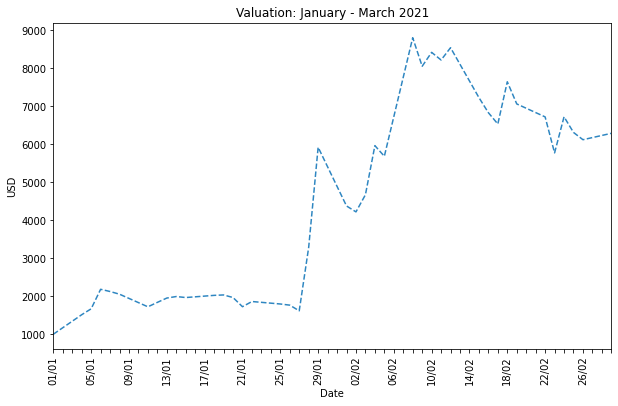

In [216]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    [parse(d) for d in valuation_all["Analytic/default/ValuationDate"]],
    valuation_all["Sum(Holding/default/PV)"], 
    color='#2e86c1', 
    linestyle='--',
)
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(DayLocator())
ax.xaxis.set_major_formatter(DateFormatter('%d/%m'))
ax.margins(x=0)
ax.set_title('Valuation: January - March 2021')
ax.set_ylabel('USD')
ax.set_xlabel("Date")
every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)       
ax

plt.savefig("data/valuation-jan2021.svg")

In January 2021 we peaked around 29th January 2021 and then it went down a little bit in the following days, before a big increase at the beginning of February. 

Let's see the breakdown of our portfolio's value by instrument. First we'll run a valuation grouped by both valuation date and instrument name:

In [213]:
response = compute_valuation_with_default_recipe(
    portfolio_code,
    datetime(year=2021, month=1, day=1, tzinfo=pytz.UTC),
    datetime(year=2021, month=3, day=1, tzinfo=pytz.UTC),
    metrics=[
        ("Instrument/default/Name", "Value"),
        ("Analytic/default/ValuationDate", "Value"),
        ("Holding/default/PV", "Value"),
    ],
    group_by=["Instrument/default/Name", "Analytic/default/ValuationDate"]
)
valuation = pd.DataFrame(response)
valuation = valuation.sort_values(["Analytic/default/ValuationDate"])
valuation.loc[:, "Analytic/default/ValuationDate"] = [parse(d) for d in valuation["Analytic/default/ValuationDate"]]
valuation.head()

,Instrument/default/Name,Analytic/default/ValuationDate,Holding/default/PV
90,USD,2021-01-01 00:00:00+00:00,1000.000000
54,USD,2021-01-04 00:00:00+00:00,2.803000
56,Stellar,2021-01-04 00:00:00+00:00,624.741457
55,Dogecoin,2021-01-04 00:00:00+00:00,885.994399
8,Stellar,2021-01-05 00:00:00+00:00,771.584463


And now let's plot it:

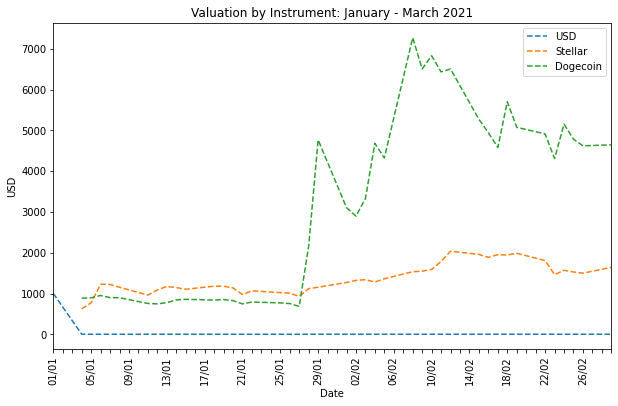

In [214]:
fig, ax = plt.subplots(figsize=(10, 6))
for instrument in valuation["Instrument/default/Name"].unique():
    usd = valuation[valuation["Instrument/default/Name"] == instrument]
    ax.plot(
        usd["Analytic/default/ValuationDate"],
        usd["Holding/default/PV"], 
        linestyle='--',
        label=instrument
    )

plt.xticks(rotation=90)
ax.margins(x=0)
ax.xaxis.set_major_locator(DayLocator())
ax.xaxis.set_major_formatter(DateFormatter('%d/%m'))
ax.set_title('Valuation by Instrument: January - March 2021')
ax.set_ylabel('USD')
ax.set_xlabel("Date")
every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)    
plt.legend()
ax

plt.savefig("data/valuation-instrument-jan2021.svg")

Stellar has slightly increased since January, but it's Dogecoin that's made the real gains. Let's imagine that we decide to diversify our Cryptocurrency a bit. We're going to sell half of our Dogecoin and buy some XRP in its place.

In [203]:
transactions_file = "data/transactions_march2021.csv"
transactions = pd.read_csv(transactions_file)
transactions

,txn_id,trade_date,transaction_type,instrument_desc,instrument_id,currency,quantity,price,net_money
0,tx_00004,2021-03-03,Sell,Dogecoin,DOGE,USD,46000,0.050441,2320.283189
1,tx_00005,2021-03-03,Buy,XRP,XRP,USD,5355,0.433193,2319.749155


In [204]:
transactions_request = []
for row, txn in transactions.iterrows():
    if txn["instrument_id"] == "cash":
        instrument_identifier = {"Instrument/default/Currency": txn["currency"]}
    else:
        instrument_identifier = {"Instrument/default/ClientInternal": txn["instrument_id"]}

    transactions_request.append(
        lusid.models.TransactionRequest(
            transaction_id=txn["txn_id"],
            type=txn["transaction_type"],
            instrument_identifiers=instrument_identifier,
            transaction_date=pytz.UTC.localize(parse(txn["trade_date"])),
            settlement_date=pytz.UTC.localize(parse(txn["trade_date"])),
            units=txn["quantity"],
            transaction_price=lusid.models.TransactionPrice(price=txn["price"], type="Price"),
            total_consideration=lusid.models.CurrencyAndAmount(
                amount=txn["net_money"], currency=txn["currency"])))

response = transaction_portfolios_api.upsert_transactions(
    scope=scope, code=portfolio_code, transaction_request=transactions_request)

Once we've done that we can run a valuation for the first 5 months of the year:

In [220]:
response = compute_valuation_with_default_recipe(
    portfolio_code,
    datetime(year=2021, month=1, day=1, tzinfo=pytz.UTC),
    datetime(year=2021, month=5, day=5, tzinfo=pytz.UTC),
    metrics=[
        ("Analytic/default/ValuationDate", "Value"),
        ("Holding/default/PV", "Sum"),
    ],
    group_by=["Analytic/default/ValuationDate"]
)
valuation_all = pd.DataFrame(response)
valuation_all = valuation_all.sort_values(["Analytic/default/ValuationDate"])
valuation_all.loc[:, "Analytic/default/ValuationDate"] = [parse(d) for d in valuation_all["Analytic/default/ValuationDate"]]
valuation_all.head()

,Analytic/default/ValuationDate,Sum(Holding/default/PV)
43,2021-01-01 00:00:00+00:00,1000.000000
32,2021-01-04 00:00:00+00:00,1513.538856
59,2021-01-05 00:00:00+00:00,1669.501555
74,2021-01-06 00:00:00+00:00,2182.928619
85,2021-01-07 00:00:00+00:00,2124.743398


In [218]:
response = compute_valuation_with_default_recipe(
    portfolio_code,
    datetime(year=2021, month=1, day=1, tzinfo=pytz.UTC),
    datetime(year=2021, month=5, day=5, tzinfo=pytz.UTC),
    metrics=[
        ("Instrument/default/Name", "Value"),
        ("Analytic/default/ValuationDate", "Value"),
        ("Holding/default/PV", "Value"),
    ],
    group_by=["Instrument/default/Name", "Analytic/default/ValuationDate"]
)
valuation = pd.DataFrame(response)
valuation = valuation.sort_values(["Analytic/default/ValuationDate"])
valuation.loc[:, "Analytic/default/ValuationDate"] = [parse(d) for d in valuation["Analytic/default/ValuationDate"]]
valuation.head()

,Instrument/default/Name,Analytic/default/ValuationDate,Holding/default/PV
150,USD,2021-01-01 00:00:00+00:00,1000.000000
112,Stellar,2021-01-04 00:00:00+00:00,624.741457
110,USD,2021-01-04 00:00:00+00:00,2.803000
111,Dogecoin,2021-01-04 00:00:00+00:00,885.994399
208,Dogecoin,2021-01-05 00:00:00+00:00,895.114092


And now let's create a chart that contains the value of our entire portfolio and the value per instrument:

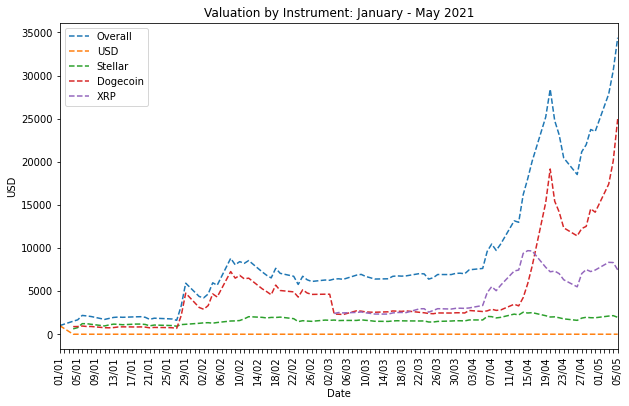

In [221]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(
        valuation_all["Analytic/default/ValuationDate"],
        valuation_all["Sum(Holding/default/PV)"], 
        linestyle='--',
        label="Overall"
)

for instrument in valuation["Instrument/default/Name"].unique():
    usd = valuation[valuation["Instrument/default/Name"] == instrument]
    ax.plot(
        usd["Analytic/default/ValuationDate"],
        usd["Holding/default/PV"], 
        linestyle='--',
        label=instrument
    )

plt.xticks(rotation=90)
ax.margins(x=0)
ax.xaxis.set_major_locator(DayLocator())
ax.xaxis.set_major_formatter(DateFormatter('%d/%m'))
ax.set_title('Valuation by Instrument: January - May 2021')
ax.set_ylabel('USD')
ax.set_xlabel("Date")
every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)    
plt.legend()
ax

plt.savefig("data/valuation-may2021.svg")

We can see a dip in the value of Dogecoin at the beginning of March, which corresponds to use selling half of our position. The line for XRP also appears at that date, since that's when we bought some XRP.

We've made a lot of money, but could we have made more?!


## What if analysis

Now for the fun stuff! What if we didn't do those transactions on 3rd March 2021, where we sold half of our DOGE and bought XRP with the receipts?

We can work this out by following these three steps: 

* Create a derived portfolio of our initial portfolio
* Remove the 3rd March 2021 transactions from the derived portfolio
* Run the valuation on the derived portfolio

Our initial portfolio will remain untouched, but we'll re-run the valuation on our initial portfolio to make sure

In [222]:
derived_portfolio_code = f"Developer-WhatIf-Tutorial-Derived-{now}"

derived_request = lusid.models.CreateDerivedTransactionPortfolioRequest(
    display_name=f"Derived Portfolio of {portfolio_code}",
    code=derived_portfolio_code,
    parent_portfolio_id=lusid.models.ResourceId(scope=scope, code=portfolio_code),
    description="What if we didn't sell DOGE?",
    created=created_date
)

response = derived_api.create_derived_portfolio(
    scope=scope,
    create_derived_transaction_portfolio_request=derived_request
)

Let's delete the transactions on 3rd March 2021, which have the transactions IDs `tx_00004` and `tx_00005`:

In [223]:
response = transaction_portfolios_api.cancel_transactions(
        scope=scope,
        code=derived_portfolio_code,
        transaction_ids=["tx_00004", "tx_00005"]
)

And now we can run a valuation on our initial portfolio and the derived one to see the difference that those trades have made on our portfolio's valuation:

In [230]:
response = compute_valuation_with_default_recipe(
    portfolio_code,
    datetime(year=2021, month=1, day=1, tzinfo=pytz.UTC),
    datetime(year=2021, month=5, day=5, tzinfo=pytz.UTC),
    metrics=[
        ("Analytic/default/ValuationDate", "Value"),
        ("Holding/default/PV", "Sum"),
    ],
    group_by=["Analytic/default/ValuationDate"]
)
valuation_initial = pd.DataFrame(response)
valuation_initial = valuation_initial.sort_values(["Analytic/default/ValuationDate"])
valuation_initial.loc[:, "Analytic/default/ValuationDate"] = [parse(d) for d in valuation_initial["Analytic/default/ValuationDate"]]
valuation_initial.head()

,Analytic/default/ValuationDate,Sum(Holding/default/PV)
61,2021-01-01 00:00:00+00:00,1000.000000
32,2021-01-04 00:00:00+00:00,1513.538856
3,2021-01-05 00:00:00+00:00,1669.501555
1,2021-01-06 00:00:00+00:00,2182.928619
81,2021-01-07 00:00:00+00:00,2124.743398


In [232]:
response = compute_valuation_with_default_recipe(
    derived_portfolio_code,
    datetime(year=2021, month=1, day=1, tzinfo=pytz.UTC),
    datetime(year=2021, month=5, day=5, tzinfo=pytz.UTC),
    metrics=[
        ("Analytic/default/ValuationDate", "Value"),
        ("Holding/default/PV", "Sum"),
    ],
    group_by=["Analytic/default/ValuationDate"]
)
valuation_hodl = pd.DataFrame(response)
valuation_hodl = valuation_hodl.sort_values(["Analytic/default/ValuationDate"])
valuation_hodl.loc[:, "Analytic/default/ValuationDate"] = [parse(d) for d in valuation_hodl["Analytic/default/ValuationDate"]]
valuation_hodl.head()

,Analytic/default/ValuationDate,Sum(Holding/default/PV)
74,2021-01-01 00:00:00+00:00,1000.000000
70,2021-01-04 00:00:00+00:00,1513.538856
19,2021-01-05 00:00:00+00:00,1669.501555
46,2021-01-06 00:00:00+00:00,2182.928619
65,2021-01-07 00:00:00+00:00,2124.743398


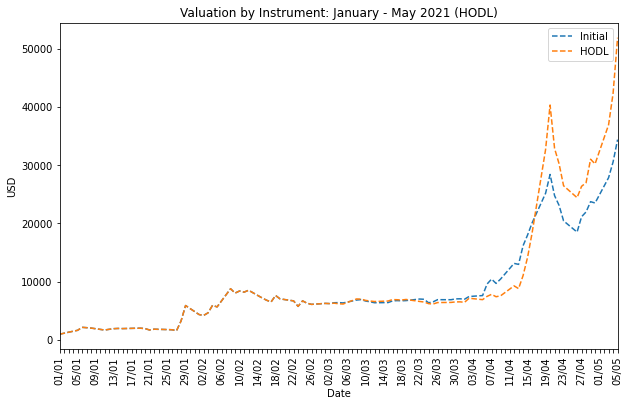

In [234]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(
        valuation_all["Analytic/default/ValuationDate"],
        valuation_all["Sum(Holding/default/PV)"], 
        linestyle='--',
        label="Initial"
)

ax.plot(
        valuation_hodl["Analytic/default/ValuationDate"],
        valuation_hodl["Sum(Holding/default/PV)"], 
        linestyle='--',
        label="HODL"
)


plt.xticks(rotation=90)
ax.margins(x=0)
ax.xaxis.set_major_locator(DayLocator())
ax.xaxis.set_major_formatter(DateFormatter('%d/%m'))
ax.set_title('Valuation by Instrument: January - May 2021 (HODL)')
ax.set_ylabel('USD')
ax.set_xlabel("Date")
every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)    
plt.legend()
ax

plt.savefig("data/valuation-may2021-hodl.svg")

At the top we see the valuation of our portfolio and underneath is a valuation if we hadn't done the trades. We can see that had we not done those trades our portfolio would now be worth 54,710 USD instead of 34,046 USD and Dogecoin would be making up 99% of our portfolio's value.

Mind you, given we started out with $1,000 cash, we're still winning!

In [54]:
recipe_api = api_factory.build(lusid.api.ConfigurationRecipeApi)

response = recipe_api.upsert_configuration_recipe(
            upsert_recipe_request=lusid.models.UpsertRecipeRequest(
                configuration_recipe=lusid.models.ConfigurationRecipe(
                    scope=scope,
                    code=portfolio_code,
                    market=lusid.models.MarketContext(
                        options=lusid.models.MarketOptions(
                            default_supplier="Lusid",
                            default_instrument_code_type="LusidInstrumentId",
                            default_scope=scope)))))